# Data Preparation

In [134]:
import os
import json
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pymysql
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import skew, kurtosis, probplot

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from arch import arch_model

In [135]:
# 1) load your creds
load_dotenv()
user     = os.getenv("MYSQL_USER")
raw_pw   = os.getenv("MYSQL_PASSWORD")
password = urllib.parse.quote_plus(raw_pw)
host     = os.getenv("MYSQL_HOST")
port     = os.getenv("MYSQL_PORT")
db       = os.getenv("MYSQL_DATABASE")

# 2) build the engine
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}")

In [136]:
df_tf = pd.read_sql_query(
    "SELECT DISTINCT timeframe FROM ohlcv ORDER BY timeframe;",
    con=engine
)
timeframes = df_tf['timeframe'].tolist()

def tf_to_minutes(tf):
    unit_minutes = {
        'm':1,
        'h':60,
        'd':60*24,
        'w':60*24*7
    }
    value, unit = int(tf[:-1]), tf[-1]
    return value*unit_minutes[unit]

# Sort timeframe in ascending order
timeframes = sorted([tf for tf in timeframes if tf != '1w'], key=tf_to_minutes)
timeframes

['1m', '3m', '5m', '15m', '30m', '1h', '4h', '6h', '12h', '1d']

## Example

In [137]:
query = f"""
SELECT datetime, open, high, low, close, volume
FROM ohlcv
WHERE timeframe = '1h'
ORDER BY timestamp
"""
df = pd.read_sql_query(query, con=engine)
df.set_index('datetime', inplace=True)
print(df.dtypes)

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object


In [138]:
df.describe()

,open,high,low,close,volume
count,33269.000000,33269.000000,33269.000000,33269.000000,33269.000000
mean,46099.112352,46280.557445,45912.874663,46100.741666,412.640789
std,23273.847460,23367.389997,23178.491771,23274.856717,554.555765
min,15656.540000,15770.000000,15484.340000,15656.540000,0.029893
25%,26921.960000,26990.000000,26870.360000,26921.960000,76.982611
50%,41767.690000,41931.530000,41616.820000,41770.000000,214.790199
75%,62459.770000,62721.740000,62161.080000,62459.920000,559.853216
max,108322.460000,109900.000000,107794.040000,108322.460000,15206.868300


In [139]:
ohlcv = {}
for tf in timeframes:
    query = f"""
    SELECT datetime, open, high, low, close, volume
    FROM ohlcv
    WHERE timeframe = '{tf}'
    ORDER BY timestamp
    """
    df = pd.read_sql_query(query, con=engine)
    df.set_index('datetime', inplace=True)
    ohlcv[tf] = df


# 1. Data Validation

Tests: 
1. Datetime Integrity & Missing Intervals
- week timeframe had 198 missing week time -> drop data with week timeframe
2. Basic Value Sanity Checks between :
- no major issues
3. Cross-Field Consistency (aggregation test for adjacent timeframes)
- Upscaled 1m data to timeframe 1h and 4h by creating OHLCV data.
- no major issues: every values were within 1%
- when i set accuracy constraint as within 0.1%, there are differences particularly in volume data

In [140]:
# Container for anomaly reports
report = {}

# Define frequency mapping
freq_map = {
    '1m': 'min',
    '3m': '3min',
    '5m': '5min',
    '15m': '15min',
    '30m': '30min',
    '1h': 'h',
    '4h': '4h',
    '12h': '12h',
    '1d': 'D',
    '1w': 'W',
}

# 1) Timestamp Integrity & Missing Intervals
timestamps_diff = {}
for tf, df_ohlcv in ohlcv.items():
    idx = df_ohlcv.index
    # Monotonicity & uniqueness
    report[f"{tf}_monotonic"] = idx.is_monotonic_increasing
    report[f"{tf}_unique"] = idx.is_unique

    # Otherwise build the expected full range
    full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
    missing = full_range.difference(idx)

    report[f"{tf}_missing_count"] = len(missing)
    report[f"{tf}_missing_samples_head"] = missing.astype(str).tolist()

# 2) Basic Value Sanity Checks
for tf, df_ohlcv in ohlcv.items():
    cond_price = (df_ohlcv['high'] >= df_ohlcv[['open','close','low']].max(axis=1)) & \
                 (df_ohlcv['low']  <= df_ohlcv[['open','close','high']].min(axis=1))
    cond_volume = df_ohlcv['volume'] >= 0
    cond_positive = (df_ohlcv[['open','high','low','close']] > 0).all(axis=1)
    invalid = df_ohlcv.index[~(cond_price & cond_volume & cond_positive)]
    report[f"{tf}_value_violations"] = len(invalid)
    report[f"{tf}_value_violation_samples"] = invalid.astype(str).tolist()

# 3) Cross-Field Consistency (aggregation test for adjacent timeframes)
pairs = [('1m','1h'), ('1m','4h')]
for low_tf, high_tf in pairs:
    df_low  = ohlcv[low_tf].copy()
    df_high = ohlcv[high_tf]

    # resample the lower timeframe to the higher timeframe
    agg = df_low.resample(freq_map[high_tf]).agg({
        'open':   'first',
        'high':   'max',
        'low':    'min',
        'close':  'last',
        'volume': 'sum'
    })

    # Compare to the “official” higher timeframe
    common_idx = df_high.index.intersection(agg.index)
    mismatches = {}
    for col in ['open','high','low','close','volume']:
        diff = (agg.loc[common_idx, col] - df_high.loc[common_idx, col])/df_high.loc[common_idx, col] > 1e-2
        mismatches[col] = int(diff.sum())
        mismatches_samples = agg[diff] - df_high[diff]
       
    report[f"{low_tf}_to_{high_tf}_mismatches"] = mismatches

# 7) Save anomaly report to JSON
with open('validation_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("Data validation complete. See validation_report.json for details.")

/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_18963/1789437839.py:27: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_18963/1789437839.py:27: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_18963/1789437839.py:27: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_18963/1789437839.py:27: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), f

Data validation complete. See validation_report.json for details.


# 2. Description Statistics & Return Distribution for log return in closed price and volume.

1. log return in closed price is roughly symmetric, near-Gaussian but have fat tail.
2. volume is highly skewed, heavy-tailed, non-negative

## A. log return in closed price

In [141]:
rets = {}
for tf in timeframes:
    df = ohlcv[tf]
    rets[tf] = np.log(df['close'] / df['close'].shift(1)).dropna()

stats = []
for tf, series in rets.items():
    stats.append({
        'timeframe': tf,
        'mean': series.mean(),
        'std': series.std(),
        'skew': skew(series),
        'kurtosis': kurtosis(series)
    })
stats_df = pd.DataFrame(stats)
print("Descriptive Statistics:")
print(stats_df)
    
n = len(timeframes)
cols = 4
rows = math.ceil(n / cols)

Descriptive Statistics:
  timeframe          mean       std      skew    kurtosis
0        1m  4.847337e-07  0.000795 -0.273562  116.350507
1        3m  9.800510e-07  0.001613 -0.084904   90.280380
2        5m  2.518084e-06  0.002139 -0.922980  107.906163
3       15m  7.246309e-06  0.003017 -0.437497   50.471648
4       30m  1.450003e-05  0.004238 -0.376501   21.404091
5        1h  2.894845e-05  0.005919 -0.157904   12.098270
6        4h  1.152040e-04  0.011714 -0.105154    7.064387
7        6h  1.724454e-04  0.014452 -0.041134    6.531422
8       12h  3.446498e-04  0.020863 -0.151711    5.016134
9        1d  6.892551e-04  0.029197 -0.179701    3.375157


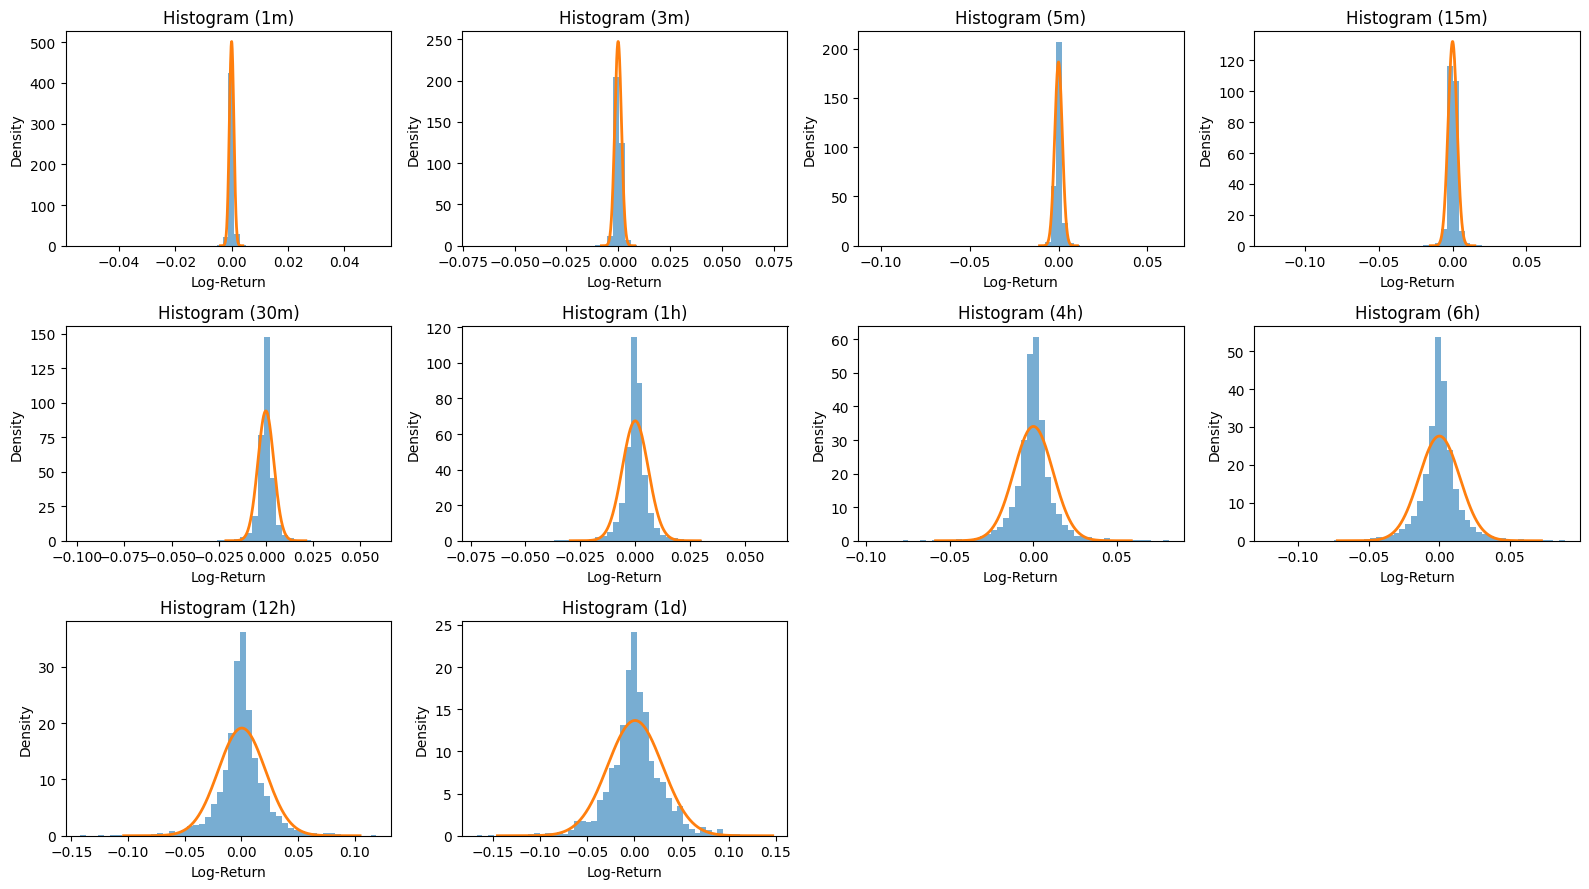

In [142]:
from scipy.stats import norm                               # ← approach 2

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax     = axes[i]
    series = rets[tf]

    ax.hist(series, bins=50, density=True, alpha=0.6)

    mu, sigma = series.mean(), series.std(ddof=0)
    lo, hi    = mu - 5*sigma, mu + 5*sigma                 # ← approach 1
    x         = np.linspace(lo, hi, 200)
    pdf       = norm.pdf(x, loc=mu, scale=sigma)           # ← approach 2

    ax.plot(x, pdf, linewidth=2)
    ax.set_title(f"Histogram ({tf})")
    ax.set_xlabel("Log‑Return")
    ax.set_ylabel("Density")

# turn off any unused axes
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


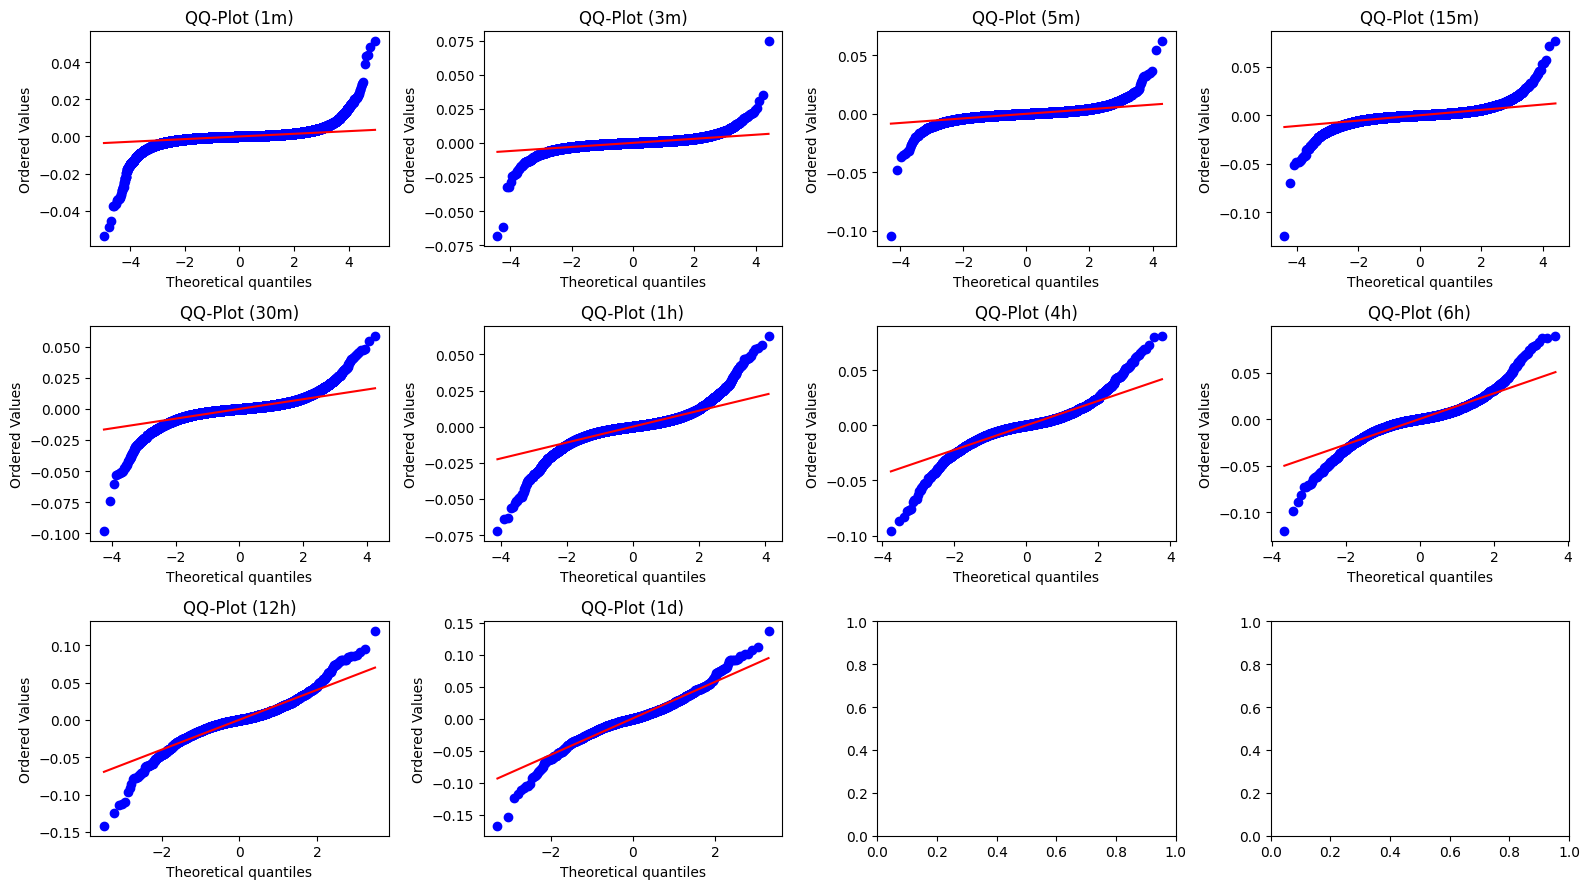

In [143]:
# 2) QQ-Plots vs. Gaussian
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    probplot(rets[tf], dist="norm", plot=ax)
    ax.set_title(f"QQ-Plot ({tf})")
fig.tight_layout()
plt.show()



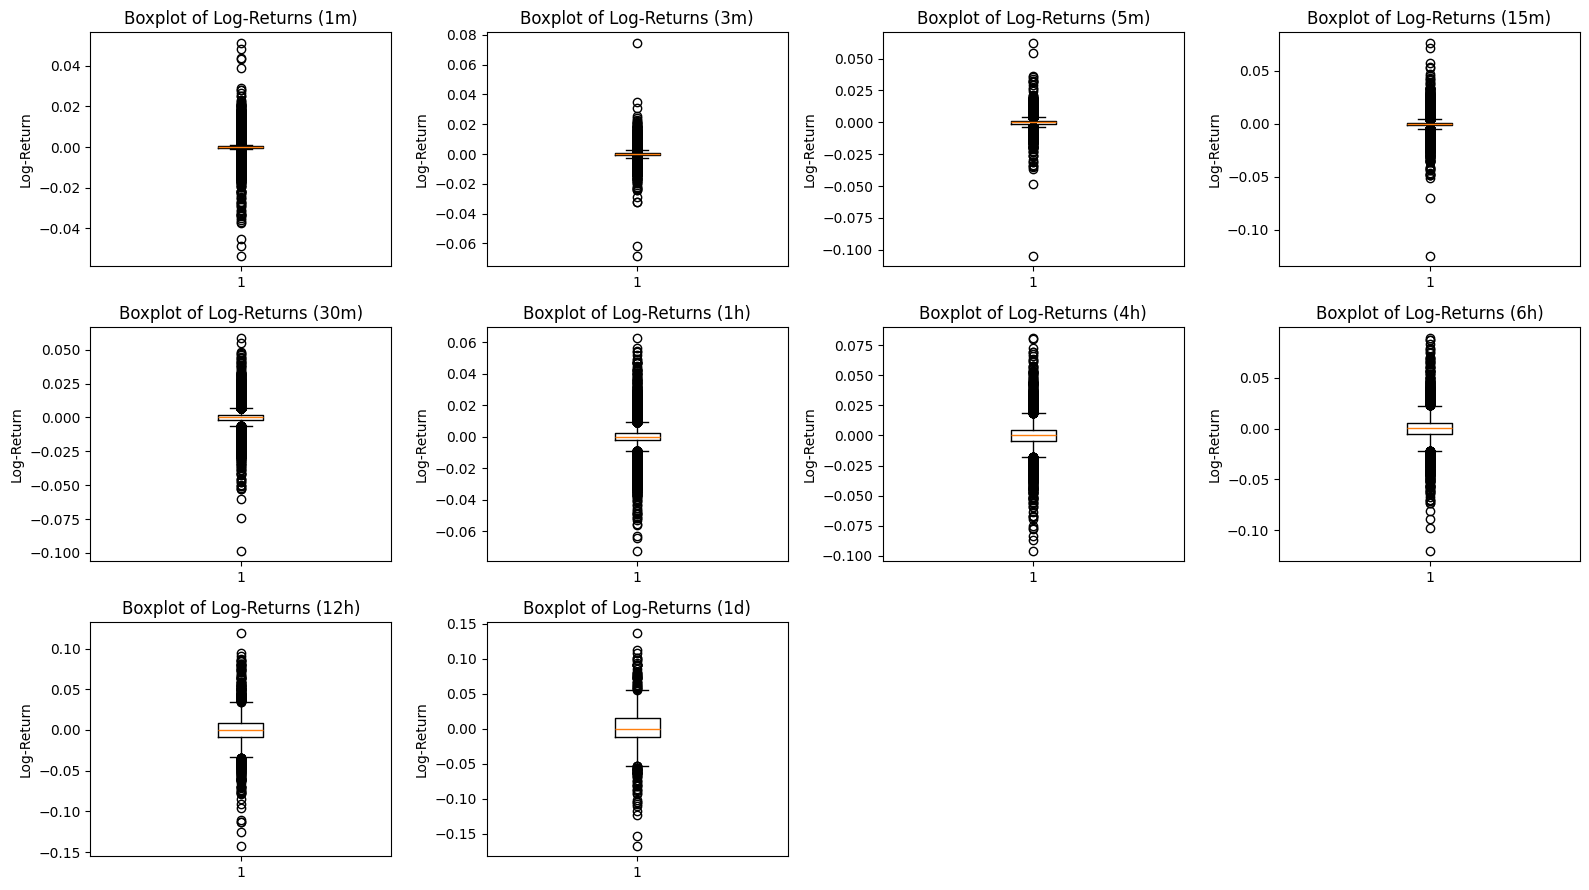

In [144]:
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    ax.boxplot(rets[tf])
    ax.set_title(f"Boxplot of Log-Returns ({tf})")
    ax.set_ylabel("Log-Return")

# Remove any unused subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

## B. Volume

In [145]:
vols = {}
for tf in timeframes:
    df = ohlcv[tf]
    vols[tf] = df['volume'].dropna()

stats = []
for tf, series in vols.items():
    stats.append({
        'timeframe': tf,
        'mean': series.mean(),
        'std': series.std(),
        'skew': skew(series),
        'kurtosis': kurtosis(series)
    })
stats_df = pd.DataFrame(stats)
print("Descriptive Statistics:")
print(stats_df)

Descriptive Statistics:
  timeframe         mean          std       skew    kurtosis
0        1m     6.877351    13.876782  13.673232  515.689593
1        3m     2.654538     5.051986   6.167093   75.302764
2        5m     4.115128     7.343988   5.966664   76.494564
3       15m   103.428632   158.037660   7.175418  138.074587
4       30m   206.894445   296.452096   5.706723   81.121227
5        1h   412.640789   554.555765   4.651351   53.703196
6        4h  1650.421516  1930.430241   2.726215   14.993340
7        6h  2475.781109  2796.187645   2.383740   10.227281
8       12h  4950.669440  5244.719156   1.959227    6.298233
9        1d  9897.779388  9895.263577   1.728416    4.691651


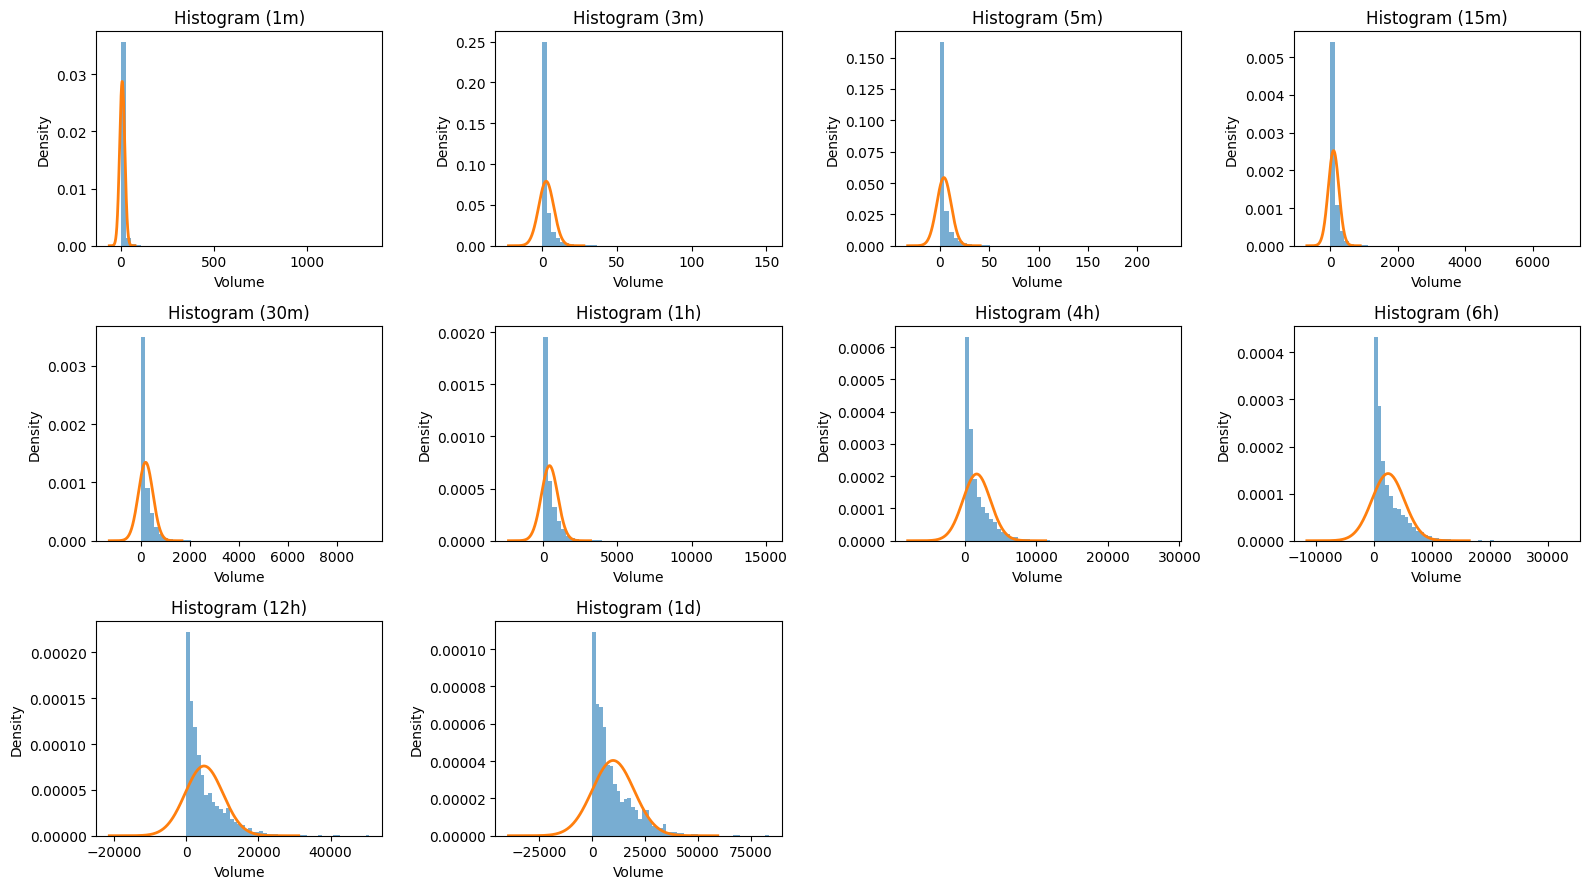

In [146]:
n, cols = len(timeframes), 4
rows    = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax     = axes[i]
    series = vols[tf]

    ax.hist(series, bins=50, density=True, alpha=0.6)

    mu, sigma = series.mean(), series.std(ddof=0)
    k         = 5                                     # 5‑sigma window
    x         = np.linspace(mu - k*sigma, mu + k*sigma, 200)
    pdf       = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-((x-mu)**2)/(2*sigma**2))

    ax.plot(x, pdf, linewidth=2)
    ax.set_title(f"Histogram ({tf})")
    ax.set_xlabel("Volume")
    ax.set_ylabel("Density")

# delete any unused axes
for j in range(n, rows*cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

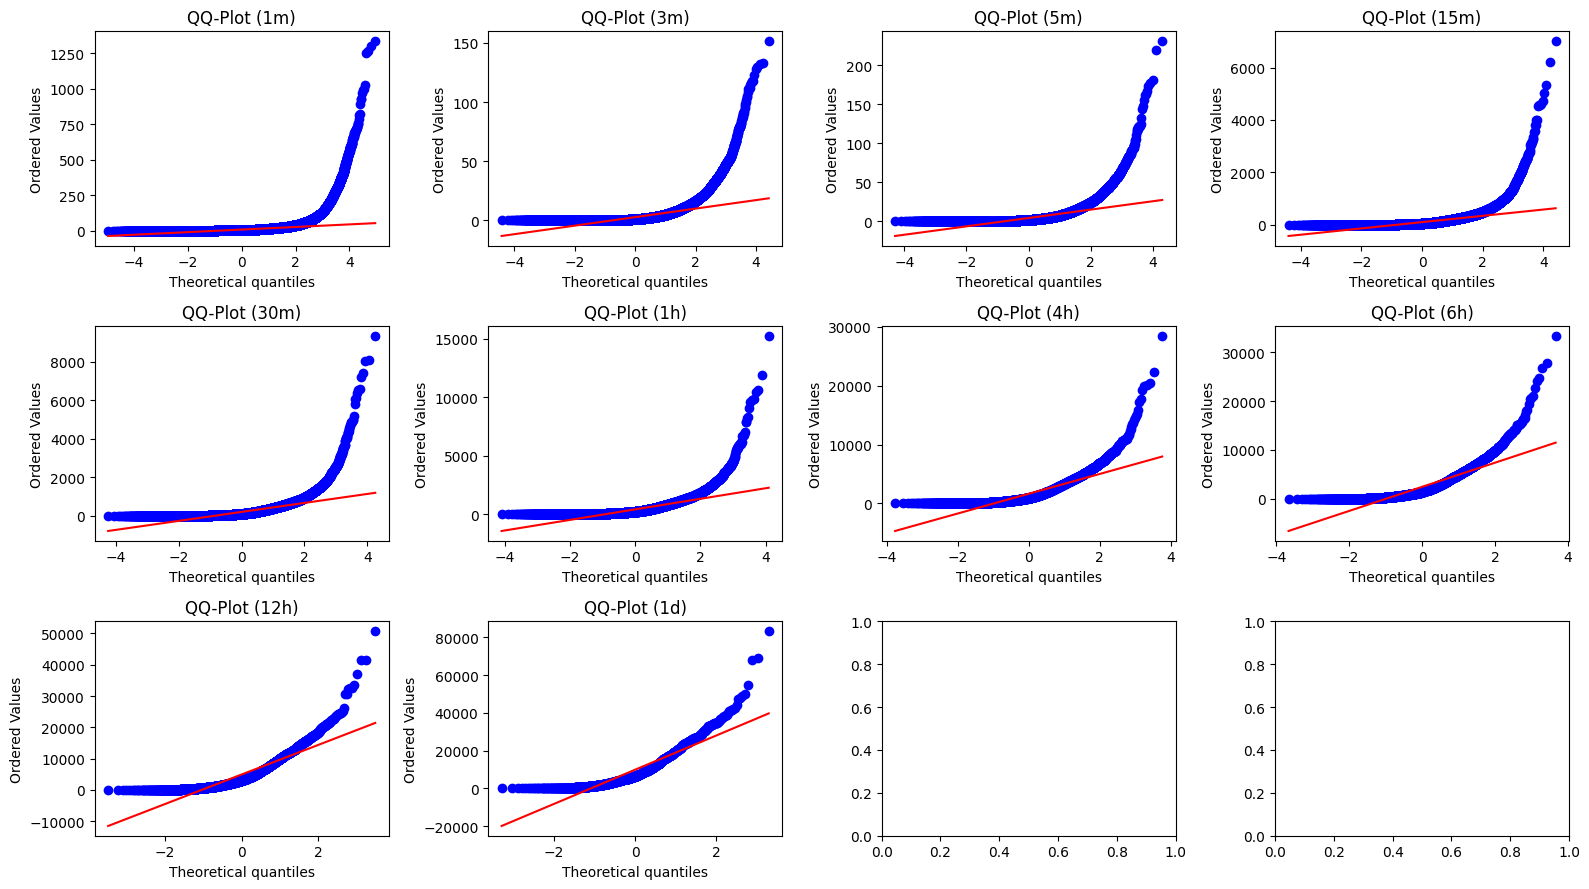

In [147]:
# 2) QQ-Plots vs. Gaussian
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    probplot(vols[tf], dist="norm", plot=ax)
    ax.set_title(f"QQ-Plot ({tf})")
fig.tight_layout()
plt.show()



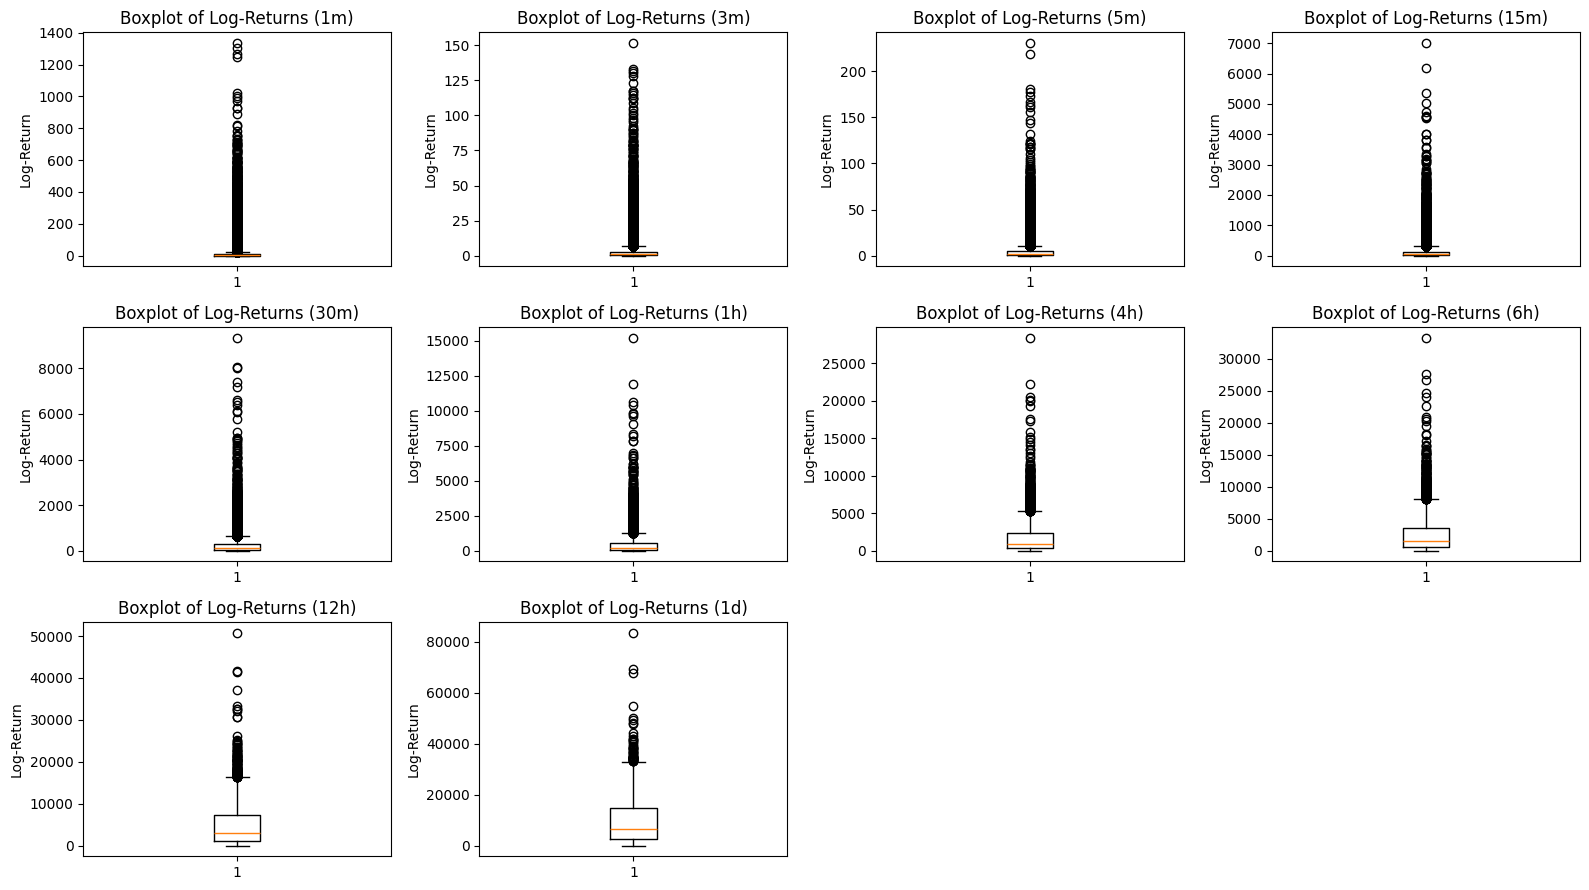

In [148]:
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    ax.boxplot(vols[tf])
    ax.set_title(f"Boxplot of Log-Returns ({tf})")
    ax.set_ylabel("Log-Return")

# Remove any unused subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

# 3. Stationary & Autocorrelation 

ADF Test
- Check Stationary of price vs returns on each timeframe

ACF and Partial ACF Test
- plot ACF/PACF of returns and absolute returns (volatility) to identify memory
- helps decide how many lags to include in your sequence window

Result: 
- ADF Test reveasl that log return has stationary distribution
- log return is white noise: pure randomness, by definition it has zero autocorrelation at all non-zero lags. 
- No AR or MA structure to exploit.

## ADF Test

In [149]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

rets = {}
for tf in timeframes:
    df = ohlcv[tf]
    rets[tf] = np.log(df['close'] / df['close'].shift(1)).dropna()

adf_stat, p_value, used_lag, n_obs, crit_vals, icbest = adfuller(rets['1h'])
print("ADF Statistic:  ", adf_stat)
print("p-value:        ", p_value)
print("# lags used:    ", used_lag)
print("# observations: ", n_obs)
print("Critical values:")
for k, v in crit_vals.items():
    print(f"    {k}: {v:.3f}")

if p_value < 0.05:
    print("Series is stationary (reject H0 at 5% level).")
else:
    print("Series is non‐stationary (fail to reject H0).")

ADF Statistic:   -37.64740469846958
p-value:         0.0
# lags used:     24
# observations:  33243
Critical values:
    1%: -3.431
    5%: -2.862
    10%: -2.567
Series is stationary (reject H0 at 5% level).


## ACF and PACF Test

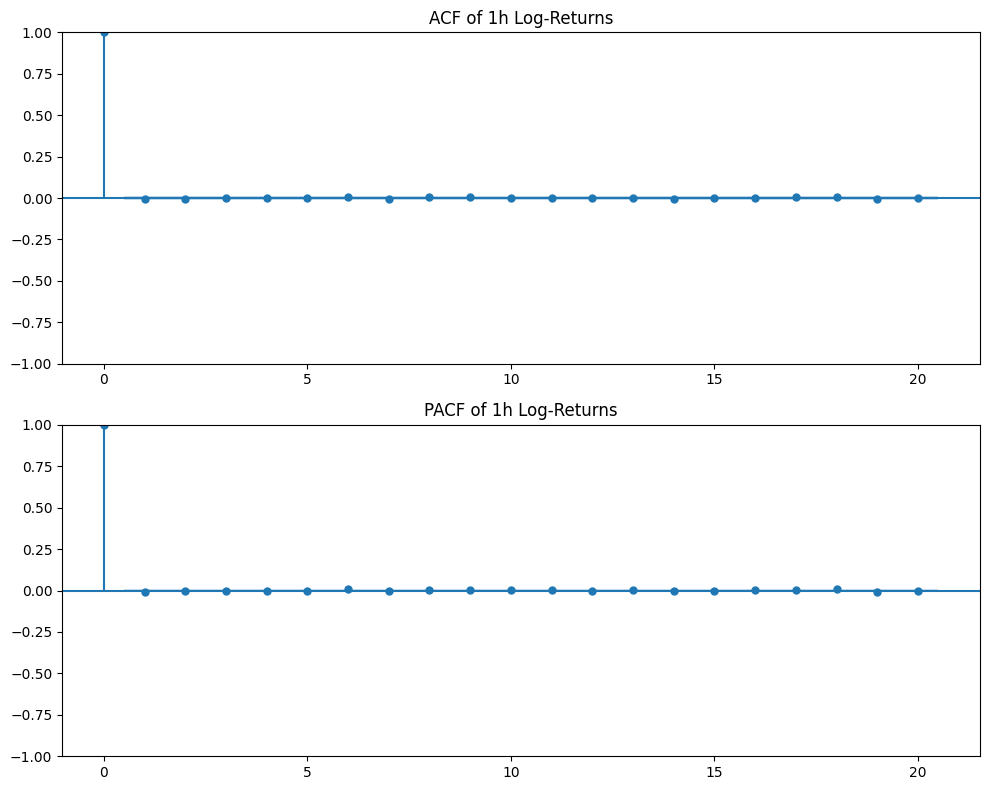

In [150]:
nlags = 20
tf = '1h'
acf_vals  = acf(rets[tf], nlags=nlags, fft=True)
pacf_vals = pacf(rets[tf], nlags=nlags, method='ywmle')

acf_df  = pd.DataFrame({'lag': np.arange(len(acf_vals)),  'acf': acf_vals})
pacf_df = pd.DataFrame({'lag': np.arange(len(pacf_vals)), 'pacf': pacf_vals})

# --- 4) ACF / PACF plots ---
fig, axes = plt.subplots(2,1, figsize=(10,8))
plot_acf(rets['1h'], lags=nlags, ax=axes[0], title="ACF of 1h Log-Returns")
plot_pacf(rets['1h'], lags=nlags, ax=axes[1], title="PACF of 1h Log-Returns")
plt.tight_layout()
plt.show()

# Correlation and Cross-Correlation for Lead-Lag Timeframes

- Results show that there is low correlation between different timeframes.
- Timeframes with lag = 0, +-k show high correlation, but that is due to look ahead bias. 
- Need to watch out for look ahead bias when comparing between different timeframe.

In [151]:
rets = {}
for tf in timeframes:
    df = ohlcv[tf]
    rets[tf] = np.log(df['close'] / df['close'].shift(1)).dropna()

# 1) Correlation matrices
rets_df = pd.DataFrame(rets)  # align on timestamp, NaNs where missing
rets_df.head()


,1m,3m,5m,15m,30m,1h,4h,6h,12h,1d
datetime,,,,,,,,,,
2021-07-05 12:01:00,0.002572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-05 12:02:00,0.000139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-05 12:03:00,0.000350,0.000373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-05 12:04:00,0.000448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-05 12:05:00,-0.000426,NaN,-0.002111,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Correlation for timeframe pairs in lag = 0

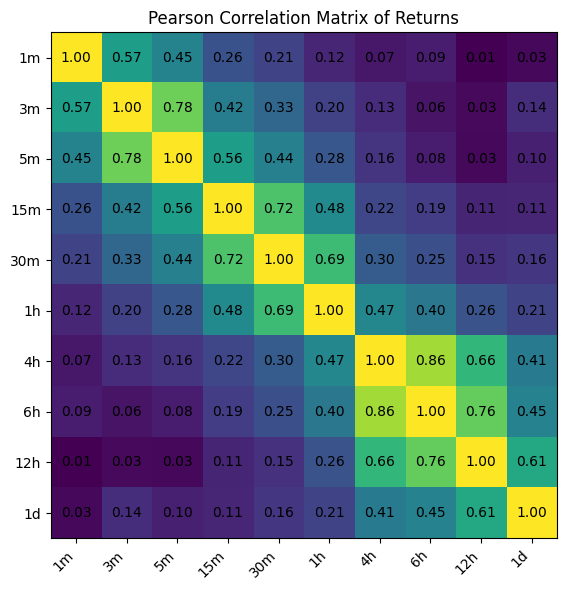

In [152]:
pearson_corr = rets_df.corr(method='pearson')

fig, ax = plt.subplots(figsize=(8, 6))
# draw the matrix
im = ax.imshow(pearson_corr.values, aspect='equal')

# tick marks and labels
n = len(pearson_corr)
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(pearson_corr.columns, rotation=45, ha='right')
ax.set_yticklabels(pearson_corr.index)

# annotate each cell with its correlation value
for (i, j), val in np.ndenumerate(pearson_corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center')

ax.set_title("Pearson Correlation Matrix of Returns")
plt.tight_layout()
plt.show()

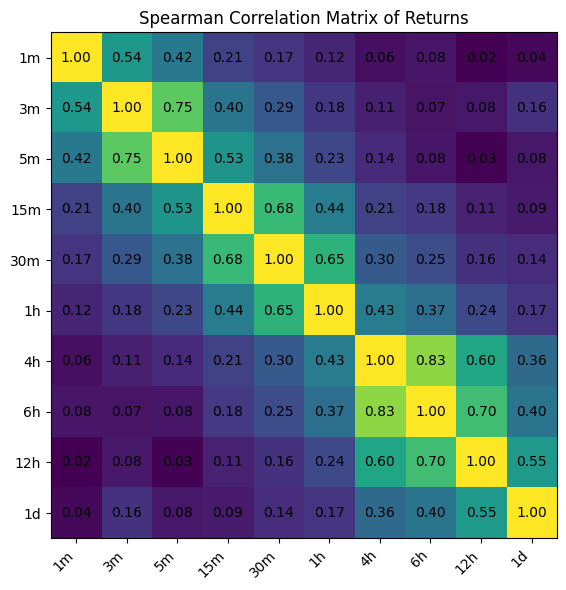

In [153]:
spearman_corr = rets_df.corr(method='spearman')

fig, ax = plt.subplots(figsize=(8, 6))
# draw the matrix
im = ax.imshow(spearman_corr.values, aspect='equal')

# tick marks and labels
n = len(spearman_corr)
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(spearman_corr.columns, rotation=45, ha='right')
ax.set_yticklabels(spearman_corr.index)

# annotate each cell with its correlation value
for (i, j), val in np.ndenumerate(spearman_corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center')

ax.set_title("Spearman Correlation Matrix of Returns")
plt.tight_layout()
plt.show()

## Correlation between pairs of timeframe with lag k without lookahead bias

In [154]:
# -----------------------------------------------------------------
# 1.  Utility: timeframe string -> seconds
# -----------------------------------------------------------------
_units = {'m':60, 'h':3600, 'd':86400, 'w':604800}

def tf_seconds(tf: str) -> int:
    """'15m' → 900   '6h' → 21600   '1d' → 86400"""
    num, unit = int(tf[:-1]), tf[-1].lower()
    return num * _units[unit]

# -----------------------------------------------------------------
# 2.  Lag filter that kills *all* overlap (and optional look‑ahead)
# -----------------------------------------------------------------
def safe_lags(tf1: str, tf2: str, max_lag: int, allow_lookahead=False):
    """Return lags k where the tf2‑bar at t+k does NOT overlap tf1‑bar at t"""
    D1, D2 = tf_seconds(tf1), tf_seconds(tf2)
    keep = []
    for k in range(-max_lag, max_lag + 1):
        if k == 0:
            continue                          # same bar → overlap
        # window maths, set t = 0 for convenience
        s1_start, s1_end   = -D1, 0
        s2_end             = k * D2
        s2_start           = s2_end - D2
        overlap = (s1_start < s2_end) and (s2_start < s1_end)
        if not overlap and (allow_lookahead or k < 0):
            keep.append(k)
    return keep

# -----------------------------------------------------------------
# 3.  Safe cross‑correlation
# -----------------------------------------------------------------
def cross_correlation_safe(s1: pd.Series,
                           s2: pd.Series,
                           tf1: str,
                           tf2: str,
                           max_lag: int,
                           allow_lookahead=False):
    lags = safe_lags(tf1, tf2, max_lag, allow_lookahead)
    cors = [s1.corr(s2.shift(-k)) for k in lags]    # shift so s2[t] → s2[t+k]
    return pd.Series(cors, index=lags)

# -----------------------------------------------------------------
# 4.  Auto‑scan without leakage
# -----------------------------------------------------------------
results = []
for tf1, s1 in rets.items():
    for tf2, s2 in rets.items():
        if tf1 == tf2:
            continue
        cc = cross_correlation_safe(s1, s2, tf1, tf2, max_lag=20,
                                    allow_lookahead=False)  # forbid future data
        if cc.empty:
            continue
        best_k = cc.abs().idxmax()
        results.append({
            'leader': tf2,          # tf2 leads (because k < 0)
            'follower': tf1,
            'best_lag': best_k,
            'corr':     cc.loc[best_k]
        })

df_leadlag = (pd.DataFrame(results)
              .sort_values('corr', ascending=False)
              .reset_index(drop=True))

print("\nLead–lag pairs without overlap / look‑ahead:")
print(df_leadlag.head(20))



Lead–lag pairs without overlap / look‑ahead:
   leader follower  best_lag      corr
0      1d       5m       -16  0.147300
1      1d       3m       -16  0.140626
2      1d       1m       -13  0.087617
3      1d      12h        -3  0.082245
4      6h       1d        -4  0.074219
5     12h       1d       -18  0.069660
6      6h      12h        -6  0.060944
7      1d       6h        -3  0.059202
8      4h       1d        -6  0.055400
9      1d       4h        -4  0.055224
10     6h      30m       -15  0.047488
11     6h       1h       -15  0.047416
12     6h      15m       -15  0.039635
13    12h       1h       -12  0.037704
14     1h       1m        -3  0.036704
15     5m      30m        -7  0.035179
16     5m      15m        -3  0.034758
17     3m      15m        -5  0.033486
18    30m       6h       -16  0.031880
19    15m       4h       -17  0.030660


# Volatility & Regime Analysis 

Analysis:
1. Hurst exponent H > 0.5 at every timeframe. This means returns are positively autocorrelated; moves tend to continue across many bars. Momentum, breakout scalping rules are favored.
2. Both rolling std and GARCH std histograms spike close to 0 and tail off. This means market spends >= 80% of the time in a low-vol, punctuated by large shocks -> fat tailed vol distribution.
3. vol

In [158]:
import warnings, numpy as np, pandas as pd
from arch import arch_model
from hurst import compute_Hc

window = 20
summary_rows, detail = [], {}

for tf, df in ohlcv.items():

    # ------------------------------------------------------------------ #
    # 1. Rolling σ
    # ------------------------------------------------------------------ #
    df['roll_std'] = (df['close'].rolling(window).std(ddof=0)
                      if len(df) >= window else np.nan)

    # ------------------------------------------------------------------ #
    # 2. GARCH(1,1)
    # ------------------------------------------------------------------ #
    ret = np.log(df['close']).diff().dropna() * 100        # %
    if len(ret) < 100 or ret.std() < 1e-6:
        df['garch_cond_vol'] = np.nan                      # <- skip
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                gm = arch_model(ret, mean='zero', vol='Garch', p=1, q=1)
                res = gm.fit(disp='off', options={'maxiter': 500}, tol=1e-7)
                df.loc[res.conditional_volatility.index,
                       'garch_cond_vol'] = res.conditional_volatility / 100
            except Exception:
                df['garch_cond_vol'] = np.nan

    # ------------------------------------------------------------------ #
    # 3. Hurst exponent
    # ------------------------------------------------------------------ #
    n = len(df['close'].dropna())
    if n >= 64:
        try:
            h, _, _ = compute_Hc(df['close'].dropna(),
                                 kind='price',
                                 min_window=max(16, n // 20),
                                 max_window=max(32, n // 2))
        except Exception:
            h = np.nan
    else:
        h = np.nan

    # ------------------------------------------------------------------ #
    summary_rows.append({
        'timeframe'      : tf,
        'last_roll_std'  : df['roll_std'].iloc[-1],
        'last_garch_vol' : df['garch_cond_vol'].iloc[-1],
        'hurst'          : h
    })
    detail[tf] = df

summary = (pd.DataFrame(summary_rows)
           .set_index('timeframe')
           .sort_index())

print(summary.round(4))

/Users/donggyulee/anaconda3/envs/myenv/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


           last_roll_std  last_garch_vol   hurst
timeframe                                       
12h             998.2171          0.0173  0.8669
15m             473.6840          0.0033  0.8445
1d             2641.2712          0.0240  0.8746
1h              919.4993          0.0061  0.8422
1m               87.1747          0.0005  0.8414
30m             422.5083          0.0052  0.8433
3m               44.1729          0.0011  0.6132
4h             1198.8939          0.0097  0.8513
5m               64.7555          0.0016  0.6096
6h             1000.3965          0.0118  0.8524


## Rolling σ histograms

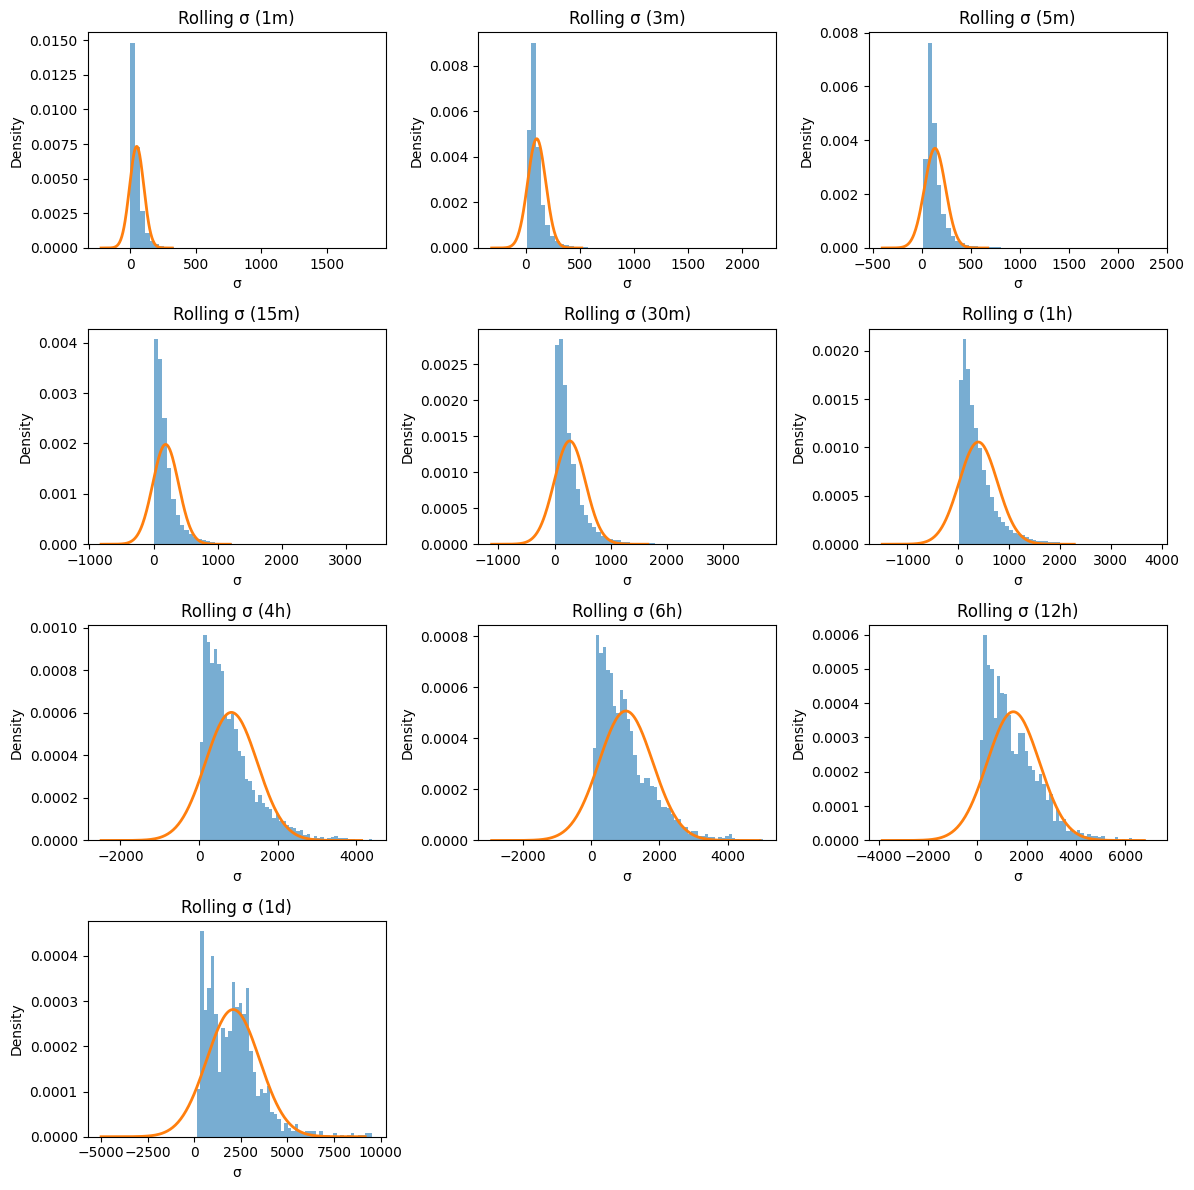

In [159]:
import math, numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm

cols = 3
rows = math.ceil(len(timeframes) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    series = detail[tf]['roll_std'].dropna()

    ax.hist(series, bins=50, density=True, alpha=0.6)

    if len(series) > 1:                          # overlay Normal fit
        mu, sigma = series.mean(), series.std(ddof=0)
        lo, hi    = mu - 5 * sigma, mu + 5 * sigma
        x         = np.linspace(lo, hi, 200)
        ax.plot(x, norm.pdf(x, mu, sigma), linewidth=2)

    ax.set_title(f"Rolling σ ({tf})")
    ax.set_xlabel("σ")
    ax.set_ylabel("Density")

# tidy up any unused panels
for j in range(len(timeframes), rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


## GARCH σ histograms

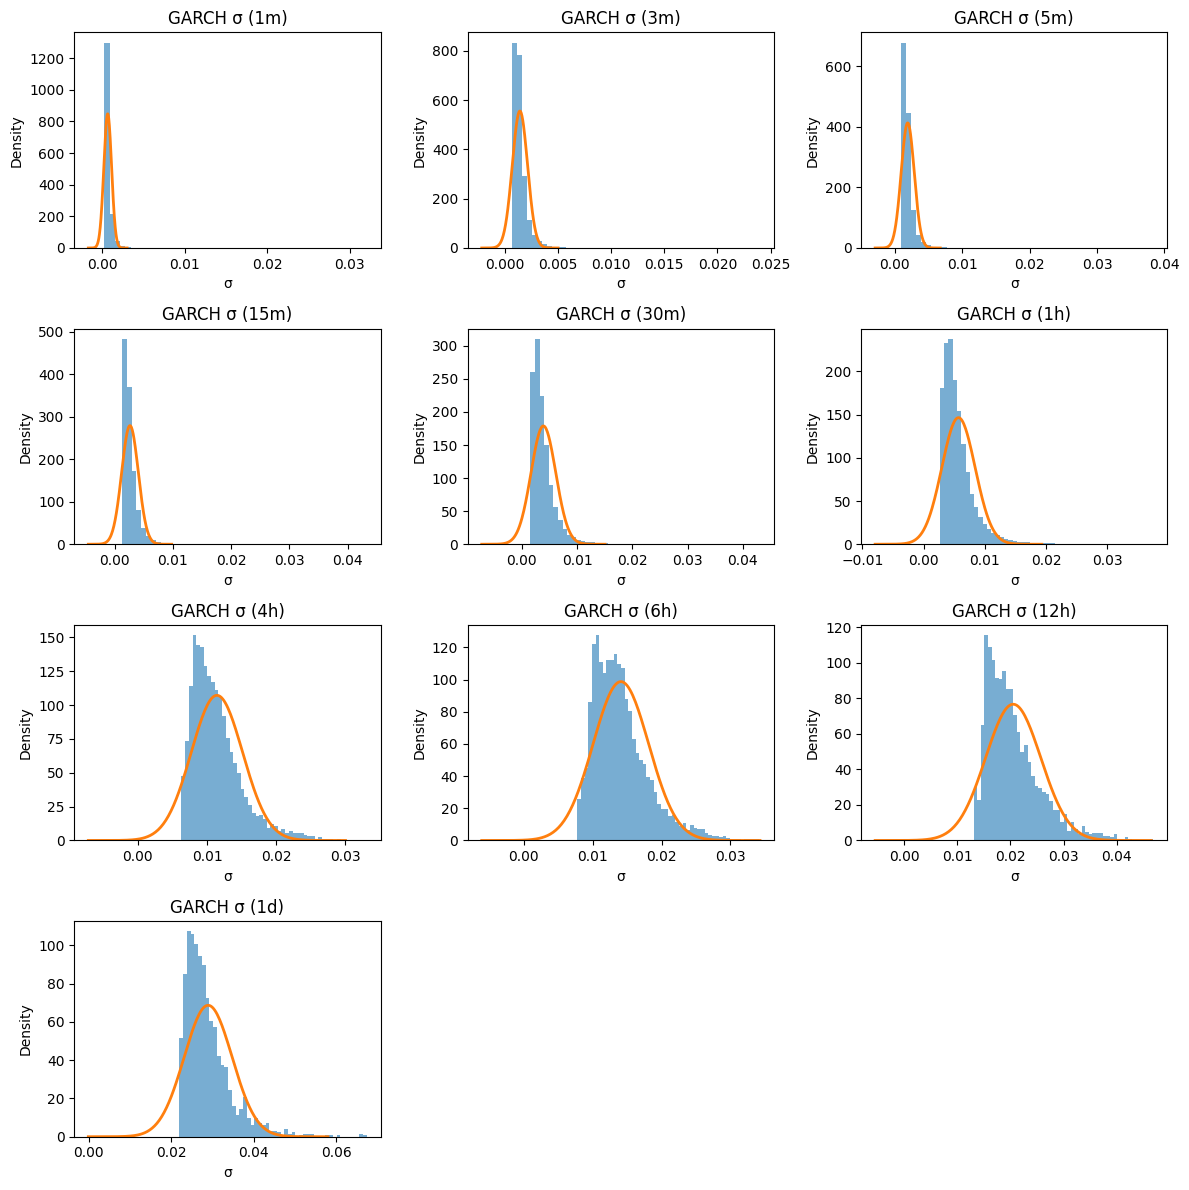

In [ ]:
import math, numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm

cols = 3
rows = math.ceil(len(timeframes) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    series = detail[tf]['garch_cond_vol'].dropna()

    ax.hist(series, bins=50, density=True, alpha=0.6)

    if len(series) > 1:
        mu, sigma = series.mean(), series.std(ddof=0)
        lo, hi    = mu - 5 * sigma, mu + 5 * sigma
        x         = np.linspace(lo, hi, 200)
        ax.plot(x, norm.pdf(x, mu, sigma), linewidth=2)

    ax.set_title(f"GARCH σ ({tf})")
    ax.set_xlabel("σ")
    ax.set_ylabel("Density")

for j in range(len(timeframes), rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


## Hurst Exponent

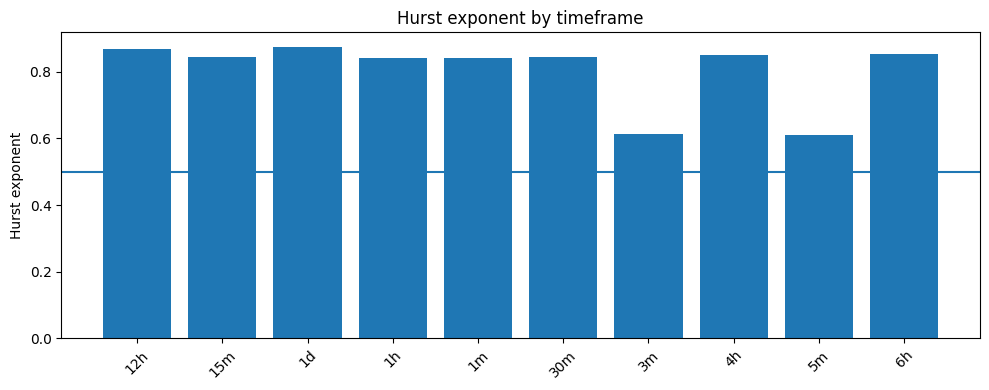

In [161]:
# ──────────────────────────────────────────────────────────────────────────────
# 3) Hurst exponent – bar chart across all timeframes
# ──────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(max(6, len(timeframes)), 4))

ax.bar(summary.index, summary['hurst'])
ax.axhline(0.5)                     # reference: random‑walk
ax.set_ylabel("Hurst exponent")
ax.set_title("Hurst exponent by timeframe")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Seasonality & Periodicity
- No significant seasonal, periodic trend

## Intraday seasonality – returns & volume by *hour of day*

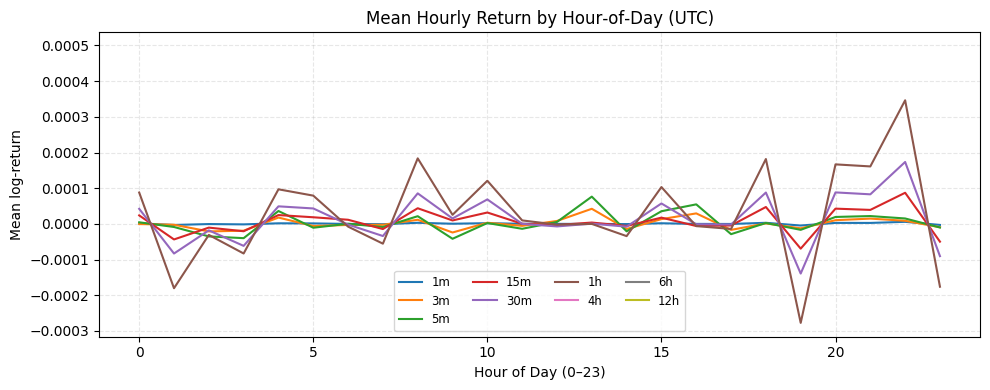

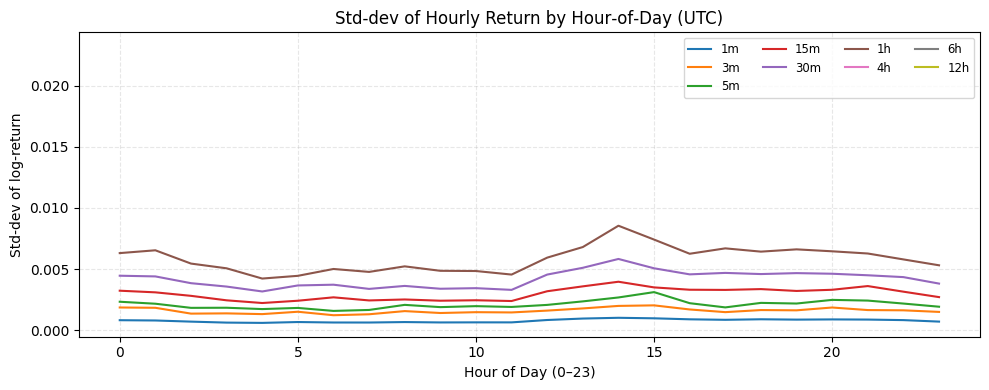

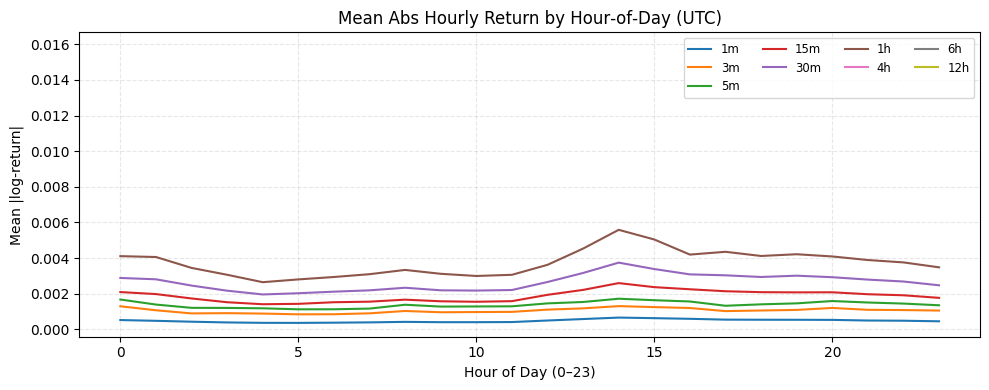

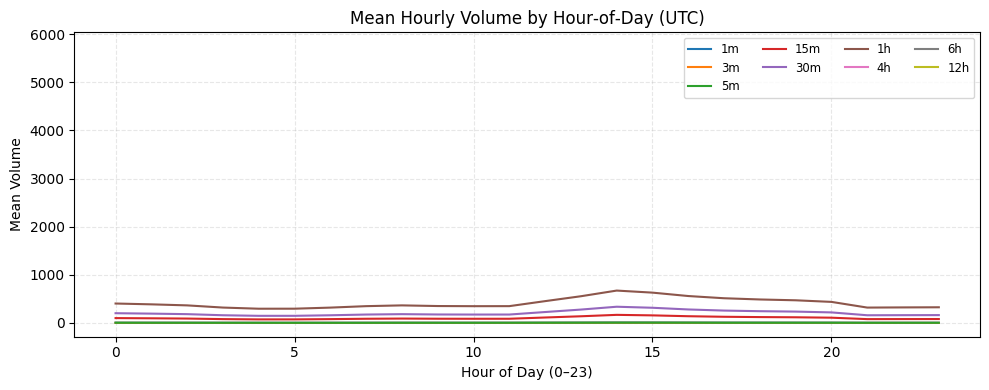

In [ ]:
from collections import OrderedDict

# helper: turn the timeframe string ('1m','3m','1h', ...) into a pandas Timedelta
def tf_to_timedelta(tf):
    if tf.endswith('m'):
        return pd.Timedelta(minutes=int(tf[:-1]))
    elif tf.endswith('h'):
        return pd.Timedelta(hours=int(tf[:-1]))
    elif tf.endswith('d'):
        return pd.Timedelta(days=int(tf[:-1]))
    else:
        raise ValueError(f"Unknown tf format: {tf}")

intraday_hour_stats = OrderedDict()

for tf, df in ohlcv.items():
    if tf_to_timedelta(tf) < pd.Timedelta('1D'):          # keep only intraday frames
        tmp          = df.copy()
        tmp['ret']   = np.log(tmp['close']).diff()        # log‑return
        tmp['hour']  = tmp.index.hour                     # 0 … 23  (assumes UTC in DB)

        stats = (tmp
                 .groupby('hour')
                 .agg(mean_ret       = ('ret', 'mean'),
                      std_ret        = ('ret', 'std'),
                      mean_abs_ret   = ('ret', lambda x: np.abs(x).mean()),
                      mean_volume    = ('volume', 'mean'),
                      obs_count      = ('ret', 'count'))
                 .assign(ann_return = lambda x: x['mean_ret'] * 24 * 365))  # optional

        intraday_hour_stats[tf] = stats

# Ensure `intraday_hour_stats` exists in the user namespace
try:
    intraday_hour_stats
except NameError:
    raise RuntimeError("`intraday_hour_stats` is not defined. Please run the seasonality aggregation code first.")

# Metrics to plot: (column name, y‑axis label, plot title suffix)
metrics = [
    ('mean_ret',      'Mean log‑return',            'Mean Hourly Return'),
    ('std_ret',       'Std‑dev of log‑return',      'Std‑dev of Hourly Return'),
    ('mean_abs_ret',  'Mean |log‑return|',          'Mean Abs Hourly Return'),
    ('mean_volume',   'Mean Volume',                'Mean Hourly Volume')
]

# Create one figure per metric, each containing all timeframes’ lines
for col, ylab, title_suf in metrics:
    fig, ax = plt.subplots(figsize=(10, 4))
    
    for tf, tbl in intraday_hour_stats.items():
        # make sure the series is aligned on 0‑23 hours (missing → NaN)
        s = tbl[col].reindex(range(24))
        ax.plot(s.index, s.values, label=tf)
    
    ax.set_title(f"{title_suf} by Hour‑of‑Day (UTC)")
    ax.set_xlabel("Hour of Day (0–23)")
    ax.set_ylabel(ylab)
    ax.legend(ncol=4, fontsize='small')
    ax.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

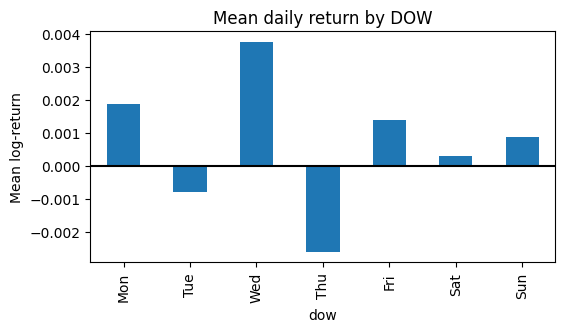

In [172]:
# ──────────────────────────────────────────────────────────────────────────────
# 2. Day‑of‑week seasonality on daily bars
# ──────────────────────────────────────────────────────────────────────────────
if '1d' not in ohlcv:
    raise KeyError("Need a '1d' entry in ohlcv for day‑of‑week analysis.")

daily = ohlcv['1d'].copy()
daily['ret'] = np.log(daily['close']).diff()
daily['dow'] = daily.index.dayofweek          # 0=Mon … 6=Sun

dow_stats = (daily
             .groupby('dow')
             .agg(mean_ret       = ('ret', 'mean'),
                  std_ret        = ('ret', 'std'),
                  mean_abs_ret   = ('ret', lambda x: np.abs(x).mean()),
                  mean_volume    = ('volume', 'mean'),
                  obs_count      = ('ret', 'count'))
             .rename(index={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}))

# 3b.  Bar plot of mean returns by day‑of‑week
dow_stats['mean_ret'].plot(kind='bar', figsize=(6,3), title="Mean daily return by DOW")
plt.axhline(0, color='k'); plt.ylabel("Mean log‑return")
plt.show()